In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import textstat

In [19]:
# Load the ground truth
df = pd.read_csv("./data/train.csv")
print("Loaded train.csv with shape:", df.shape)

Loaded train.csv with shape: (95, 2)


In [20]:
def load_texts(row):
    folder = Path("./data/train") / f"article_{row['id']:04d}"
    with open(folder / "file_1.txt", "r", encoding="utf-8") as f1:
        text1 = f1.read()
    with open(folder / "file_2.txt", "r", encoding="utf-8") as f2:
        text2 = f2.read()
    return pd.Series([text1, text2])

In [ ]:
df[["text_1", "text_2"]] = df.apply(load_texts, axis=1)
print("Loaded all text files!")

y = (df["real_text_id"] == 2).astype(int)

Loaded all text files!


Empty text_1 count: 1
Empty text_2 count: 1
IDs with empty text_1: [14]
IDs with empty text_2: [10]

Difference in character length (text_1 - text_2):
count       95.000000
mean     -1974.378947
std       4692.485086
min     -38648.000000
25%      -1535.000000
50%       -539.000000
75%          5.500000
max       1857.000000
Name: len_diff, dtype: float64


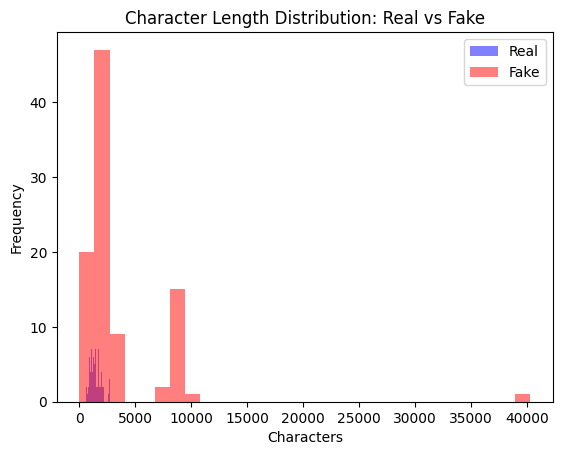

In [35]:
df["len_1"] = df["text_1"].str.len()
df["len_2"] = df["text_2"].str.len()

print("Empty text_1 count:", (df["len_1"] == 0).sum())
print("Empty text_2 count:", (df["len_2"] == 0).sum())

empty_text1_ids = df.loc[df["len_1"] == 0, "id"]
empty_text2_ids = df.loc[df["len_2"] == 0, "id"]

print("IDs with empty text_1:", empty_text1_ids.tolist())
print("IDs with empty text_2:", empty_text2_ids.tolist())

# Compare lengths
df["real_len"] = df.apply(lambda row: row["len_1"] if row["real_text_id"] == 1 else row["len_2"], axis=1)
df["fake_len"] = df.apply(lambda row: row["len_2"] if row["real_text_id"] == 1 else row["len_1"], axis=1)
df["len_diff"] = df["real_len"] - df["fake_len"]

print("\nDifference in character length (text_1 - text_2):")
print(df["len_diff"].describe())

plt.hist(df["real_len"], bins=30, alpha=0.5, label="Real", color="blue")
plt.hist(df["fake_len"], bins=30, alpha=0.5, label="Fake", color="red")
plt.legend()
plt.title("Character Length Distribution: Real vs Fake")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.show()


Difference in word count (text_1 - text_2):
count      95.000000
mean     -211.926316
std       470.149846
min     -3902.000000
25%      -246.000000
50%       -79.000000
75%        -0.500000
max       257.000000
Name: wordcount_diff, dtype: float64


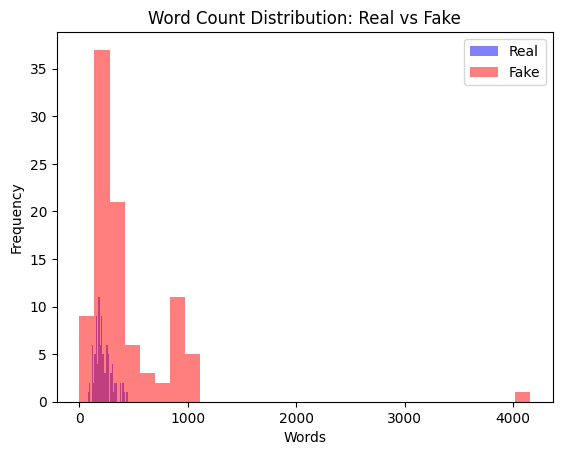

In [34]:
df["wordcount_1"] = df["text_1"].str.split().apply(len)
df["wordcount_2"] = df["text_2"].str.split().apply(len)

# Difference in length
df["real_wordcount"] = df.apply(lambda r: r["wordcount_1"] if r["real_text_id"] == 1 else r["wordcount_2"], axis=1)
df["fake_wordcount"] = df.apply(lambda r: r["wordcount_2"] if r["real_text_id"] == 1 else r["wordcount_1"], axis=1)
df["wordcount_diff"] = df["real_wordcount"] - df["fake_wordcount"]

print("\nDifference in word count (text_1 - text_2):")
print(df["wordcount_diff"].describe())

plt.hist(df["real_wordcount"], bins=30, alpha=0.5, label="Real", color="blue")
plt.hist(df["fake_wordcount"], bins=30, alpha=0.5, label="Fake", color="red")
plt.legend()
plt.title("Word Count Distribution: Real vs Fake")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()


In [36]:
# Count sentences using punctuation as delimiters
df["sent_count_1"] = df["text_1"].str.count(r'[.!?]')
df["sent_count_2"] = df["text_2"].str.count(r'[.!?]')

# Map real vs fake counts based on the label real_text_id
df["real_sent_count"] = df.apply(lambda row: row["sent_count_1"] if row["real_text_id"] == 1 else row["sent_count_2"], axis=1)
df["fake_sent_count"] = df.apply(lambda row: row["sent_count_2"] if row["real_text_id"] == 1 else row["sent_count_1"], axis=1)

# Difference (Real - Fake)
df["sent_count_diff_rf"] = df["real_sent_count"] - df["fake_sent_count"]

# Show statistics
print("Sentence Count Difference (Real - Fake):")
print(df["sent_count_diff_rf"].describe())

print("\nReal Sentence Count Stats:")
print(df["real_sent_count"].describe())

print("\nFake Sentence Count Stats:")
print(df["fake_sent_count"].describe())


Sentence Count Difference (Real - Fake):
count     95.000000
mean     -29.294737
std       63.231906
min     -455.000000
25%      -12.500000
50%       -4.000000
75%       -1.000000
max       11.000000
Name: sent_count_diff_rf, dtype: float64

Real Sentence Count Stats:
count    95.000000
mean     10.810526
std       5.151523
min       4.000000
25%       7.000000
50%      10.000000
75%      14.000000
max      27.000000
Name: real_sent_count, dtype: float64

Fake Sentence Count Stats:
count     95.000000
mean      40.105263
std       64.098075
min        0.000000
25%        9.500000
50%       14.000000
75%       27.500000
max      469.000000
Name: fake_sent_count, dtype: float64


In [37]:
# Calculate average word length for each text
df["avg_word_len_1"] = df["text_1"].apply(lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0)
df["avg_word_len_2"] = df["text_2"].apply(lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0)

# Assign real vs fake based on label
df["real_avg_word_len"] = df.apply(lambda row: row["avg_word_len_1"] if row["real_text_id"] == 1 else row["avg_word_len_2"], axis=1)
df["fake_avg_word_len"] = df.apply(lambda row: row["avg_word_len_2"] if row["real_text_id"] == 1 else row["avg_word_len_1"], axis=1)

# Difference (Real - Fake)
df["avg_word_len_diff_rf"] = df["real_avg_word_len"] - df["fake_avg_word_len"]

# Show statistics
print("Average Word Length Difference (Real - Fake):")
print(df["avg_word_len_diff_rf"].describe())

print("\nReal Avg Word Length Stats:")
print(df["real_avg_word_len"].describe())

print("\nFake Avg Word Length Stats:")
print(df["fake_avg_word_len"].describe())


Average Word Length Difference (Real - Fake):
count    95.000000
mean     -0.262784
std       1.571964
min      -3.478398
25%      -0.283179
50%       0.058457
75%       0.395185
max       6.242915
Name: avg_word_len_diff_rf, dtype: float64

Real Avg Word Length Stats:
count    95.000000
mean      5.723346
std       0.383897
min       4.754190
25%       5.449630
50%       5.739437
75%       6.048928
max       6.571429
Name: real_avg_word_len, dtype: float64

Fake Avg Word Length Stats:
count    95.000000
mean      5.986129
std       1.457295
min       0.000000
25%       5.314067
50%       5.616379
75%       6.160726
max       8.938025
Name: fake_avg_word_len, dtype: float64


In [38]:
# Calculate readability scores for both texts
df["readability_1"] = df["text_1"].apply(textstat.flesch_reading_ease)
df["readability_2"] = df["text_2"].apply(textstat.flesch_reading_ease)

# Assign real vs fake readability based on label
df["real_readability"] = df.apply(lambda row: row["readability_1"] if row["real_text_id"] == 1 else row["readability_2"], axis=1)
df["fake_readability"] = df.apply(lambda row: row["readability_2"] if row["real_text_id"] == 1 else row["readability_1"], axis=1)

# Difference between real and fake
df["readability_diff_rf"] = df["real_readability"] - df["fake_readability"]

# Show statistics
print("Average Real Readability:", df["real_readability"].mean())
print("Average Fake Readability:", df["fake_readability"].mean())

print("\nReal Text Readability Stats:")
print(df["real_readability"].describe())

print("\nFake Text Readability Stats:")
print(df["fake_readability"].describe())

print("\nDifference in Readability (Real - Fake):")
print(df["readability_diff_rf"].describe())


Average Real Readability: 25.41070049781437
Average Fake Readability: 26.568827794313403

Real Text Readability Stats:
count    95.000000
mean     25.410700
std      15.469199
min     -17.445969
25%      15.632642
50%      24.790070
75%      37.379415
max      56.119318
Name: real_readability, dtype: float64

Fake Text Readability Stats:
count    95.000000
mean     26.568828
std      19.830576
min     -66.226250
25%      11.160774
50%      28.301375
75%      39.875641
max      68.431667
Name: fake_readability, dtype: float64

Difference in Readability (Real - Fake):
count    95.000000
mean     -1.158127
std      22.253943
min     -57.016667
25%     -14.044440
50%      -1.350017
75%      11.032766
max      78.322375
Name: readability_diff_rf, dtype: float64
